In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display_html 
from datetime import datetime, timedelta
import plotly.express as px

## 1 - Ler os dados

In [137]:
EEG = pd.read_csv(r"C:\Users\anapa\Documents\gp3_mindwave_data_collection\dataset\EEG\10_12_22__14_19_piscada_4s.txt", sep="\t").reset_index().drop("Unnamed: 2", axis=1).rename(columns={"TIME":"TIME_MATLAB","index":"CNT"})
ET = pd.read_csv(r"C:\Users\anapa\Documents\gp3_mindwave_data_collection\dataset\ET\10_12_22__14_19_piscada_4s.txt", sep="\t").reset_index().drop("Unnamed: 6", axis=1).rename(columns={"index":"TIME_MATLAB"})

In [138]:
EEG["RAW_EEG"] = EEG["RAW_EEG"].astype(int)
ET["BKID"] = ET["BKID"].astype(int)

In [139]:
df1_styler = EEG[:5].style.set_table_attributes("style='display:inline'").set_caption('EEG dataset')

df2_styler = ET[:5].style.set_table_attributes("style='display:inline'").set_caption('ET dataset')

display_html(df1_styler._repr_html_() + "\t" + df2_styler._repr_html_(), raw=True)

EEG dataset CNT TIME_MATLAB RAW_EEG 
 
 0 
 0 
 738865.597100 
 112 
 
 
 1 
 1 
 738865.597100 
 107 
 
 
 2 
 2 
 738865.597100 
 106 
 
 
 3 
 3 
 738865.597100 
 104 
 
 
 4 
 4 
 738865.597100 
 102 
 
 ET dataset TIME_MATLAB TIME CNT TIME_GP3 BKID BKPMIN USER 
 
 0 
 738865.597100 
 34618 
 588.799440 
 0 
 0 
 11 
 TERMINAL2_MESSAGE 
 
 
 1 
 738865.597100 
 34619 
 588.816040 
 0 
 0 
 11 
 TERMINAL2_MESSAGE 
 
 
 2 
 738865.597100 
 34620 
 588.832280 
 0 
 0 
 11 
 TERMINAL2_MESSAGE 
 
 
 3 
 738865.597100 
 34621 
 588.848690 
 0 
 0 
 11 
 TERMINAL2_MESSAGE 
 
 
 4 
 738865.597100 
 34622 
 588.865110 
 0 
 0 
 11 
 TERMINAL2_MESSAGE

## 2 - Metadados

Duração da coleta por cada modalidade: 120 segundos

In [140]:
ET_clean = ET.loc[ET["USER"] != "NO_DATA"]
ET = ET.rename(columns={"BKID":"BKDUR"})
ET = ET.rename(columns={"TIME_GP3":"BKID"})

In [141]:
print(f"total de dados de EEG: {EEG.shape[0]}\ntotal de dados de ET: {ET.shape[0]}")
print(f"frequencia EEG: {EEG.shape[0]/120} Hz\nfrequencia ET: {ET.shape[0]/120} Hz")
print(f"frequencia ET sem nulos: {round(ET_clean.shape[0]/120, 2)} Hz")

total de dados de EEG: 52665
total de dados de ET: 13770
frequencia EEG: 438.875 Hz
frequencia ET: 114.75 Hz
frequencia ET sem nulos: 57.64 Hz


In [224]:
EEG.groupby("TIME_MATLAB").agg(frames_time = ('TIME_MATLAB','count')).mean(), ET.groupby("TIME_MATLAB").agg(frames_time = ('TIME_MATLAB','count')).mean()

(frames_time    3761.785714
 dtype: float64,
 frames_time    918.0
 dtype: float64)

# 3 - Identificação de Piscada

Aproximadamente 1 piscada a cada 4 segundos. Em uma coleta de 120 segundos, aproximadamente 30 piscadas.   
Possivelmente algumas piscadas são identificadas de forma errada.

In [155]:
total_piscadas_ET  = ET.loc[ET["BKID"] != 0]["BKID"].max() - ET.loc[ET["BKID"] != 0]["BKID"].min()
print(f"total piscadas identificadas pelo GP3: {total_piscadas_ET}")

total piscadas identificadas pelo GP3: 47


In [197]:
def matlab_time_to_date(matlab_time):
    return (datetime.fromordinal(int(matlab_time)) + timedelta(days=matlab_time%1) - timedelta(days = 366)).strftime("%H:%M:%S")

In [198]:
ET["current_time"] = ET["TIME_MATLAB"].apply(matlab_time_to_date)
EEG["current_time"] = EEG["TIME_MATLAB"].apply(matlab_time_to_date)

In [202]:
ET

TIME_MATLAB   TIME        CNT  BKID  BKDUR  BKPMIN               USER  \
0      738865.5971  34618  588.79944     0      0      11  TERMINAL2_MESSAGE   
1      738865.5971  34619  588.81604     0      0      11  TERMINAL2_MESSAGE   
2      738865.5971  34620  588.83228     0      0      11  TERMINAL2_MESSAGE   
3      738865.5971  34621  588.84869     0      0      11  TERMINAL2_MESSAGE   
4      738865.5971  34622  588.86511     0      0      11  TERMINAL2_MESSAGE   
...            ...    ...        ...   ...    ...     ...                ...   
13765  738865.5985  41533  709.23810     0      0      24         COLLECTION   
13766  738865.5985      0    0.00000     0      0       0            NO_DATA   
13767  738865.5985      0    0.00000     0      0       0            NO_DATA   
13768  738865.5985  41534  709.25488     0      0      24         COLLECTION   
13769  738865.5985      0    0.00000     0      0       0            NO_DATA   

      current_time  BLINK  
0         14:19:49      0  
1         14:19:49      0  
2         14:19:49      0  
3         14:19:49      0  
4         14:19:49      0  
...            ...    ...  
13765     14:21:50      0  
13766     14:21:50      0  
13767     14:21:50      0  
13768     14:21:50      0  
13769     14:21:50      0  

[13770 rows x 9 columns]

In [205]:
blink_duration_ET = ET.groupby("BKID").agg(frames = ('TIME_MATLAB', 'count')).reset_index()
blink_duration_ET.loc[blink_duration_ET["BKID"] != 0].frames.mean()

28.083333333333332

28.08 frames - 0.46 segundos
60 - 1 segundo

In [207]:
0.46 * 60

27.6

In [188]:
def blink(bkid):
    if bkid != 0:
        return 1
    else:
        return 0

In [189]:
ET["BLINK"] = ET["BKID"].apply(blink)

## Downsampling Python Time Series

## 4 - Interpolação -> Fill Binary Column

Não precisamos de inteprolação pois estamos medindo piscada. Podmeos fazer outra coisa, que é preencher zeros com o ultimo valor não zero, pois a coluna de ppiscda é binária.

In [210]:
from scipy.interpolate import interp1d

In [213]:
ET["after_fill"] = ET["BKID"].replace(to_replace=0, method="ffill")

In [214]:
total_piscadas_ET  = ET.loc[ET["BKID"] != 0]["BKID"].max() - ET.loc[ET["BKID"] != 0]["BKID"].min()
print(f"total piscadas identificadas pelo GP3: {total_piscadas_ET}")

total piscadas identificadas pelo GP3: 47


In [216]:
blink_duration_ET = ET.groupby("after_fill").agg(frames = ('TIME_MATLAB', 'count')).reset_index()
blink_duration_ET.loc[blink_duration_ET["after_fill"] != 0].frames.mean()

286.125

## 5 - Identificação de Piscada em EEG

In [219]:
EEG["RAW_EEG"].min()

-758

In [220]:
EEG[:1]

CNT  TIME_MATLAB  RAW_EEG current_time
0    0  738865.5971      112     14:19:49

In [233]:
import plotly.express as px

fig = px.line(EEG, x='CNT', y="RAW_EEG", labels={
                     "RAW_EEG": "RAW EEG (mV)",
                     "CNT": "Contagem (units)"
                 })
fig.add_hrect(y0=400, y1=-400, line_width=0, fillcolor="red", opacity=0.2)
fig.show()

Vamos analisar o que estamos vendo aqui. O sinal primeiro sobe e depois desce. Quando ele sobe, o sinal ultrapassa aproximadamente 400 mV.

Visualmente, podemos observar aproximadamente 38 momentos onde o sinal foi superior a 400 mV. 

Qual a média da distancia em contagem de pontos entre o pico e o vale do sinal?

Para humanamente identificar um valor de piscada típico do meu sinal, eu observaria que ele:
- Primeiro ultrapassa pela primeira vez um valor de 400.
- Quando ele ultrapassa esse valor, ele ja tinha começado a subir cerca de 39 unidades de contagem antes.
- Depois disso, o sinal desce abaixo de 400 mV dentro de até 280 unidades de CNT
- O sinal retorna para seu estado médio em aproximadamente 280 unidades contando 39 unidades antes do primeiro momento que o sinal cruza o limite de 400

In [234]:
5665 - 5704

-39

In [235]:
5941 - 5661

280

In [275]:
5705 - 39

5666

In [237]:
EEG["above_400"] = EEG["RAW_EEG"].apply(lambda x: 1 if x >= 400 else 0)
EEG["below_400"] = EEG["RAW_EEG"].apply(lambda x: 1 if x <= -400 else 0)

In [280]:
def beggings(row):
    if row["above_400"] == 1:
        return row["CNT"] - 39
    else:
        return 0

def endings(row):
    if row["beggings_CNT"] != 0:
        return row["beggings_CNT"] + 280
    else:
        return 0

In [294]:
# identificando as primeiras vezes que o valor ultrapassa a marca de 400
EEG["beggings_CNT"] = EEG.apply(beggings, axis=1)
EEG["endings_CNT"] = EEG.apply(endings, axis=1)

In [295]:

#tempo_piscadas = tempo_piscadas.loc[tempo_piscadas["above_400"] == 1]
#tempo_piscadas = tempo_piscadas.drop("above_400", axis=1)

In [306]:
tempo_piscadas = EEG[["above_400", "below_400", "beggings_CNT","endings_CNT"]]
g = tempo_piscadas['above_400'].ne(tempo_piscadas['above_400'].shift()).cumsum() 
tempo_piscadas = tempo_piscadas.groupby(g).first()[["beggings_CNT","endings_CNT"]].drop_duplicates().reset_index()

In [307]:
tempo_piscadas['zip_times'] = list(zip(tempo_piscadas.beggings_CNT, tempo_piscadas.endings_CNT))

In [315]:
contagens_piscadas = []
for contagem in EEG["CNT"]:
    # para cada contagem dos dados
    for i in tempo_piscadas.zip_times.tolist():
        # para cada possibilidade de estar entre os valores de começo e final de cada piscada
        if i[0] <= contagem <= i[1]:
            # salvar em lista os valores de CNT entre os intervalos
            contagens_piscadas.append(contagem)
        else:
            pass

In [326]:
def inside_blink_period(val):
    if val in contagens_piscadas:
        return 500
    else:
        return 0

In [327]:
EEG["piscada_potencial_EEG"] = EEG["CNT"].apply(inside_blink_period)

In [328]:
fig = px.line(EEG, x='CNT', y=["RAW_EEG", "piscada_potencial_EEG"], labels={
                     "RAW_EEG": "RAW EEG (mV)",
                     "CNT": "Contagem (units)"
                 })
fig.show()

## 6 - Plotando Piscadas no ET

In [330]:
ET["potential_blinks_ET"] = np.where(ET["BKID"] != 0, 500, 0)

In [337]:
ET = ET.reset_index().rename(columns={"index":"CNT_ET"})

In [338]:
fig = px.line(ET, x='CNT_ET', y=["potential_blinks_ET"])
fig.show()

A piscada dura aproximadamente 80 contagens. Mas ela realmente pode durar menos, e está tudo bem. Aqui queremos apenas que quando o sinal estiver muito próximo, que ele se torne identificador de piscada.

## 7 - Merge dos dois tipos de dados

Temos duas frequências distintas e queremos saber quando podemos unir as duas.   
O sinal correlato que temos é a piscada. 
Quando o dataset de EEG 439 Hz, o de ET terá 115, aproximadamente. 

In [403]:
ET_filtred = ET[["CNT_ET","TIME_MATLAB","potential_blinks_ET"]]
ET_filtred.columns = ["CNT_ET","TIME_MATLAB","piscada_potencial"]
#ET_filtred["piscada_potencial"] = ET_filtred["piscada_potencial"].replace(to_replace=0, method='ffill')
ET_filtred[320:][:100]

CNT_ET  TIME_MATLAB  piscada_potencial
320     320  738865.5972                  0
321     321  738865.5972                500
322     322  738865.5972                  0
323     323  738865.5972                500
324     324  738865.5972                  0
..      ...          ...                ...
415     415  738865.5972                  0
416     416  738865.5972                  0
417     417  738865.5972                  0
418     418  738865.5972                  0
419     419  738865.5972                  0

[100 rows x 3 columns]

In [411]:
ET_filtred.shape

(13770, 3)

In [409]:
ffil_blink_ET = ET_filtred.loc[ET_filtred.piscada_potencial == 500, ['piscada_potencial']].fillna(method='bfill', axis=1)

In [412]:
pd.merge(ET_filtred, ffil_blink_ET, left_index=True, right_index=True, how="outer")

CNT_ET  TIME_MATLAB  piscada_potencial_x  piscada_potencial_y
0           0  738865.5971                    0                  NaN
1           1  738865.5971                    0                  NaN
2           2  738865.5971                    0                  NaN
3           3  738865.5971                    0                  NaN
4           4  738865.5971                    0                  NaN
...       ...          ...                  ...                  ...
13765   13765  738865.5985                    0                  NaN
13766   13766  738865.5985                    0                  NaN
13767   13767  738865.5985                    0                  NaN
13768   13768  738865.5985                    0                  NaN
13769   13769  738865.5985                    0                  NaN

[13770 rows x 4 columns]

In [393]:
EEG_filtered = EEG[["CNT","TIME_MATLAB","piscada_potencial"]]
EEG_filtered.columns = ["CNT_EEG","TIME_MATLAB","piscada_potencial"]
EEG_filtered[5666:]

CNT_EEG  TIME_MATLAB  piscada_potencial
5666      5666  738865.5975                500
5667      5667  738865.5975                500
5668      5668  738865.5975                500
5669      5669  738865.5975                500
5670      5670  738865.5975                500
...        ...          ...                ...
52660    52660  738865.5985                  0
52661    52661  738865.5985                  0
52662    52662  738865.5985                  0
52663    52663  738865.5985                  0
52664    52664  738865.5985                  0

[46999 rows x 3 columns]

In [394]:
5666 / EEG_filtered.shape[0]

0.10758568309123706

In [397]:
ET_filtred.shape[0] / 10

1377.0

## 8 - Cross-Correlation

y2 is 1.0008140670791272 behind y1


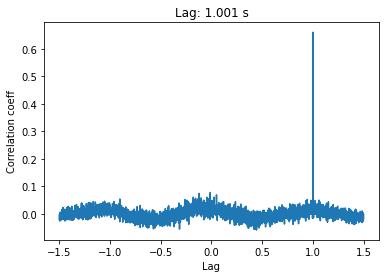

In [413]:
import matplotlib.pyplot as plt
from scipy import signal
import numpy as np


def lag_finder(y1, y2, sr):
    n = len(y1)

    corr = signal.correlate(y2, y1, mode='same') / np.sqrt(signal.correlate(y1, y1, mode='same')[int(n/2)] * signal.correlate(y2, y2, mode='same')[int(n/2)])

    delay_arr = np.linspace(-0.5*n/sr, 0.5*n/sr, n)
    delay = delay_arr[np.argmax(corr)]
    print('y2 is ' + str(delay) + ' behind y1')

    plt.figure()
    plt.plot(delay_arr, corr)
    plt.title('Lag: ' + str(np.round(delay, 3)) + ' s')
    plt.xlabel('Lag')
    plt.ylabel('Correlation coeff')
    plt.show()

# Sine sample with some noise and copy to y1 and y2 with a 1-second lag
sr = 1024
y = np.linspace(0, 2*np.pi, sr)
y = np.tile(np.sin(y), 5)
y += np.random.normal(0, 5, y.shape)
y1 = y[sr:4*sr]
y2 = y[:3*sr]

lag_finder(y1, y2, sr)

In [414]:
EEG_filtered[:2]

CNT_EEG  TIME_MATLAB  piscada_potencial
0        0  738865.5971                500
1        1  738865.5971                  0

In [415]:
ET_filtred[:2]

CNT_ET  TIME_MATLAB  piscada_potencial
0       0  738865.5971                  0
1       1  738865.5971                  0

In [ ]:
def lag_finder(y1, y2, sr):
    n = len(y1)

    corr = signal.correlate(y2, y1, mode='same') / np.sqrt(signal.correlate(y1, y1, mode='same')[int(n/2)] * signal.correlate(y2, y2, mode='same')[int(n/2)])

    delay_arr = np.linspace(-0.5*n/sr, 0.5*n/sr, n)
    delay = delay_arr[np.argmax(corr)]
    print('y2 is ' + str(delay) + ' behind y1')

    plt.figure()
    plt.plot(delay_arr, corr)
    plt.title('Lag: ' + str(np.round(delay, 3)) + ' s')
    plt.xlabel('Lag')
    plt.ylabel('Correlation coeff')
    plt.show()

# Sine sample with some noise and copy to y1 and y2 with a 1-second lag
sr = 1024 #sampling rate 
y = np.linspace(0, 2*np.pi, sr)
y = np.tile(np.sin(y), 5)
y += np.random.normal(0, 5, y.shape)
y1 = y[sr:4*sr]
y2 = y[:3*sr]

lag_finder(y1, y2, sr)

In [ ]:
EEG_filtered[]

In [416]:
import resampy
import numpy as np
import matplotlib.pyplot as plt

# after resampling one frequency should be gone
signal = np.sin(2*np.pi*150*np.linspace(0, 1, 1000)) \
        + np.sin(2*np.pi*50*np.linspace(0, 1, 1000))
resampled_signal = resampy.resample(signal, 1000, 200)


plt.figure()
plt.plot(np.linspace(0, 499, 500), np.abs(np.fft.fft(signal))[:500])
# below scaling to have same energy in spectrum
plt.plot(np.linspace(0, 99, 100), np.abs(np.fft.fft(resampled_signal))[:100] * 1000/200, 'r--')
plt.legend(['before resampling', 'after resampling'])
plt.show()

OSError: Could not find/load shared object file: llvmlite.dll
 Error was: Could not find module 'c:\Users\anapa\anaconda3\envs\gazepoint\lib\site-packages\llvmlite\binding\llvmlite.dll' (or one of its dependencies). Try using the full path with constructor syntax.

# Resample

In [ ]:
# quero sair de um sample de 439 para 115

In [419]:
EEG_filtered.shape[0]/120

438.875

In [421]:
EEG_filtered.set_index("TIME_MATLAB")

CNT_EEG  piscada_potencial
TIME_MATLAB                            
738865.5971        0                500
738865.5971        1                  0
738865.5971        2                  0
738865.5971        3                  0
738865.5971        4                  0
...              ...                ...
738865.5985    52660                  0
738865.5985    52661                  0
738865.5985    52662                  0
738865.5985    52663                  0
738865.5985    52664                  0

[52665 rows x 2 columns]

In [ ]:
EEG_filtered.resample()